# Bjerknes feedback changes over time

## imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import copy
import time

# Import custom modules
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Funcs

In [2]:
def get_dT_sub(Tsub, Hm, delta=25):
    """
    Get temperature difference b/n entrainment zone and mixed layer.
    (positive if entrainment zone is warmer than ML)
    """

    ## find indices in ML and entrainment zone (ez)
    in_ml = Tsub.z_t <= Hm
    in_ez = (Tsub.z_t > Hm) & (Tsub.z_t < (delta + Hm))

    ## get Tbar and Tplus (following Frankignoul et al paper)
    Tbar = Tsub.where(in_ml).mean("z_t")
    Tplus = Tsub.where(in_ez).mean("z_t")

    ## get gradient
    dT = Tplus - Tbar

    return dT


def prep(data):
    """remove sst dependence and compute tendencies"""

    ## remove from h indices
    for h_idx in ["h_w", "h", "h_w_z20"]:
        data[f"{h_idx}_hat"] = src.utils.remove_sst_dependence_v2(
            data, h_var=h_idx, T_var="T_34"
        )

    return data


def load_budget_data(t_early, t_late, target_grid):
    """load ground truth heat budget data"""

    def load_var(varname):
        """load variable from prepped folder"""

        ## open data
        data = xr.open_mfdataset(
            sorted(list(pathlib.Path(DATA_FP, "cesm", f"{varname}_temp").glob("*.nc"))),
            concat_dim="member",
            combine="nested",
            parallel=True,
        )

        return data.assign_coords({"member": np.arange(100)})

    ## load data
    budget_data = xr.merge([load_var(v) for v in ["adv", "ddt_T"]])

    ## get difference
    budget_data["diff"] = budget_data["TEND_TEMP"] - budget_data["ADV_3D_TEMP"]

    ## convert z coord from cm to m, and unit from K/s to K/mo
    M_PER_CM = 1e-2
    SEC_PER_MO = 8.64e4 * 30

    ## convert from (i) cm to m and (ii) K/s to K/mo
    budget_data = budget_data.assign_coords({"z_t": budget_data.z_t * M_PER_CM})
    budget_data = budget_data * SEC_PER_MO

    ## fix longitude coordinate
    budget_data = budget_data.assign_coords({"nlon": budget_data.lon.values})
    budget_data = budget_data.drop_vars("lon").rename({"nlon": "longitude"})

    ## trim in time
    budget_data = xr.concat(
        [budget_data.sel(t_early), budget_data.sel(t_late)], dim="time"
    )

    ## interpolate
    budget_data = budget_data.interp_like(target_grid)

    # ## separate forced/anomalies
    forced_bud, anom_bud = src.utils.separate_forced(budget_data)

    return forced_bud, anom_bud


def plot_mlds(axs, bar_early, bar_late, month=None):
    """plot mixed layer depth on pair of axs objects"""

    ## get longitude
    lon = src.utils.merimean(bar_early).longitude

    ## helper function to get month
    if month is None:
        sel = lambda x: x.mean("month")
    else:
        sel = lambda x: x.sel(month=month)

    ## plot
    axs[0].plot(lon, sel(src.utils.merimean(bar_early["mld"])), c="k")
    axs[1].plot(lon, sel(src.utils.merimean(bar_late["mld"])), c="k", ls="--")
    axs[2].plot(lon, sel(src.utils.merimean(bar_early["mld"])), c="k")
    axs[2].plot(lon, sel(src.utils.merimean(bar_late["mld"])), c="k", ls="--")

    return


def plot_level(ax, data, level, ls="-", c="w"):
    """plot single level on hovmoller"""
    ax.contour(
        data.longitude,
        data.z_t,
        data,
        levels=[level],
        colors=c,
        linestyles=ls,
        linewidths=1,
    )
    return

## Load data

#### $T$, $h$

In [3]:
## open data
Th = src.utils.load_cesm_indices(load_z20=True)

### Spatial data

#### Load

In [4]:
## load spatial data
forced, anom = src.utils.load_consolidated()

## add T,h information
for n in ["T_3", "T_34", "T_4", "h", "h_w", "h_w_z20", "h_z20"]:
    # anom[n] = Th[n] / Th[n].std()
    anom[n] = Th[n]

#### compute some indices

In [5]:
## get sst tendency (and convert from 1/yr to 1/mo)
anom["ddt_sst"] = 1 / 12 * src.utils.get_ddt(anom[["sst"]], is_forward=True)["ddt_sst"]

#### early/late split

In [6]:
## split into early/late periods
t_early = dict(time=slice("1851", "1880"))
# t_late = dict(time=slice("1981", "2010"))
t_late = dict(time=slice("2071", "2100"))

## split surface data
anom_early = anom.sel(t_early)
anom_late = anom.sel(t_late)

## preprocess
anom_early = prep(anom_early).compute()
anom_late = prep(anom_late).compute()

## Compute/plot

In [7]:
def get_slope_bymonth(x, **kwargs):
    """get slope for each month separately"""
    return x.groupby("time.month").map(src.utils.regress_proj, **kwargs)

### Specify variabes

In [195]:
## specify plot month
PLOT_MONTH = 5

## specify boxes for fitting
T_VAR = "T_3"
T_FN = src.utils.get_nino3
Tsub_FN = (
    lambda x, H: x.sel(longitude=slice(210, 270))
    .mean("longitude")
    .sel(z_t=H, method="nearest")
)

## specify subsetting funcs
LATS = dict(latitude=slice(-5, 5))
LATS_H = dict(latitude=slice(-2, 2))
LONS_E = dict(longitude=slice(210, 270))
LONS_W = dict(longitude=slice(140, 210))
LONS_TAU = dict(longitude=slice(150, 230))

Set funcs

In [196]:
## helper func to select and avg
sel_helper = lambda x, lats, lons: x.sel(**lats, **lons).mean(["latitude", "longitude"])

## specify functions
TAU_FN = lambda x: sel_helper(x, LATS, LONS_TAU)
He_FN = lambda x: sel_helper(x, LATS_H, LONS_E)
Hw_FN = lambda x: sel_helper(x, LATS_H, LONS_W)
Hgrad_FN = lambda x: He_FN(x) - Hw_FN(x)

### SST - SST

In [197]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="sst", fn_x=T_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)

Hovmoller

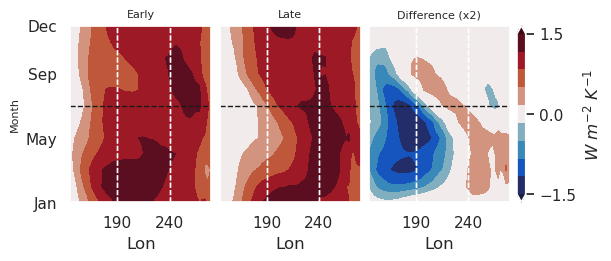

In [198]:
## shared args
kwargs = dict(amp=1.5, lat_bound=1.5)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=m_early, **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=m_late, **kwargs)
cp2 = src.utils.make_cycle_hov(axs[2], data=2 * (m_late - m_early), **kwargs)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$W~m^{-2}~K^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    ax.axhline(7, ls="--", c="k", lw=1)

plt.show()

Spatial

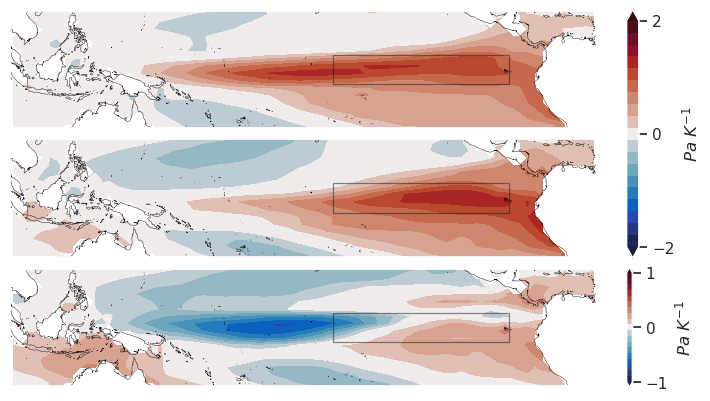

In [199]:
## select month
sel = lambda x: x.sel(month=PLOT_MONTH)

## set up plot
fig = plt.figure(figsize=(7, 3.9), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=format_func)

contour_kwargs = dict(amp=2, sel=sel)
cp0 = src.utils.make_contour_plot(axs[0, 0], m_early, **contour_kwargs)
cp1 = src.utils.make_contour_plot(axs[1, 0], m_late, **contour_kwargs)
cp2 = src.utils.make_contour_plot(
    axs[2, 0], (m_late - m_early), **dict(contour_kwargs, amp=1)
)

## colorbar
lab = r"$Pa~K^{-1}$"
cb0 = fig.colorbar(cp0, ax=axs[:2], ticks=[-2, 0, 2], label=lab)
cb2 = fig.colorbar(cp2, ax=axs[-1], ticks=[-1, 0, 1], label=lab)

## Niño 3 box
box_kwargs = dict(c="k", linewidth=0.9, alpha=0.5)
for ax in axs.flatten():
    src.utils.plot_nino3_box(ax, **box_kwargs)

plt.show()

Scatter

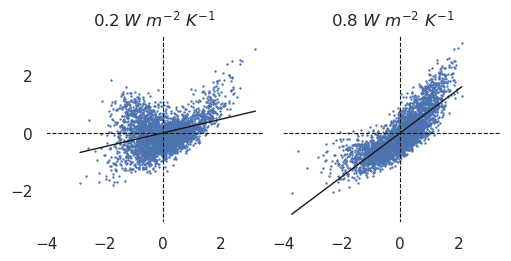

In [200]:
## specify func
grad = lambda x: src.utils.get_nino3(x) - src.utils.get_nino4(x)

## kwargs for plotting
kwargs = dict(months=PLOT_MONTH, scale=1, x_var=T_VAR, y_var="sst", fn_y=grad)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.1f}" + r" $W~m^{-2}~K^{-1}$")
axs[1].set_title(f"{m1:.1f}" + r" $W~m^{-2}~K^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

### SST - NHF

In [201]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="nhf", fn_x=T_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)
alpha = xr.merge([m_early.rename("early"), m_late.rename("late")])

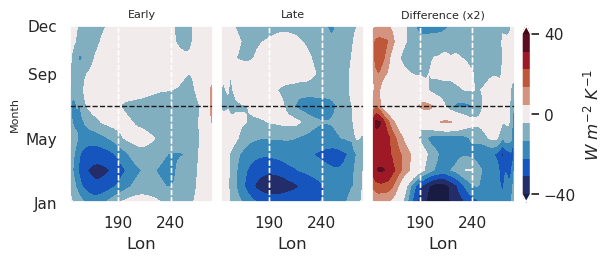

In [202]:
## shared args
kwargs = dict(amp=40, lat_bound=1.5)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=alpha["early"], **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=alpha["late"], **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * (alpha["late"] - alpha["early"]), **kwargs
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$W~m^{-2}~K^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    ax.axhline(7, ls="--", c="k", lw=1)

plt.show()

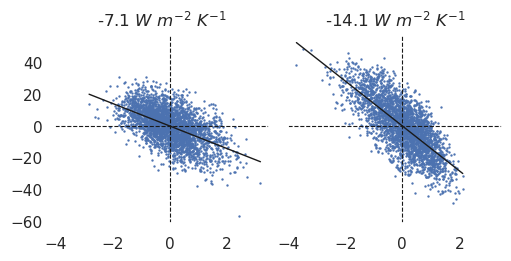

In [203]:
## kwargs for plotting
kwargs = dict(months=PLOT_MONTH, scale=1, x_var=T_VAR, y_var="nhf", fn_y=T_FN)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.1f}" + r" $W~m^{-2}~K^{-1}$")
axs[1].set_title(f"{m1:.1f}" + r" $W~m^{-2}~K^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

### SST-$\tau_x$

In [204]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="taux", fn_x=T_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)
mu_a = xr.merge([m_early.rename("early"), m_late.rename("late")])

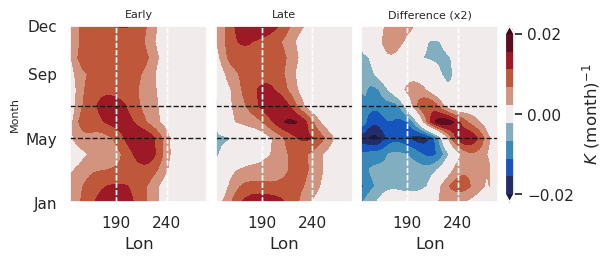

In [205]:
## shared args
kwargs = dict(amp=0.02, lat_bound=1.5)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=mu_a["early"], **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=mu_a["late"], **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * (mu_a["late"] - mu_a["early"]), **kwargs
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$K~\left(\text{month}\right)^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

##### Spatial plot

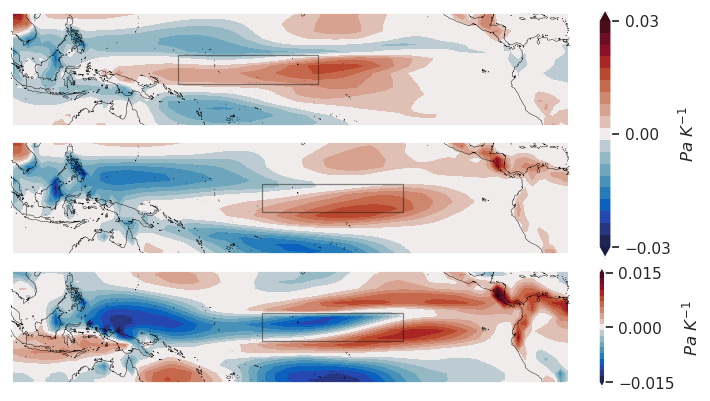

In [206]:
## select month
sel = lambda x: x.sel(month=PLOT_MONTH)

## set up plot
fig = plt.figure(figsize=(7, 3.9), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=format_func)

contour_kwargs = dict(amp=3e-2, sel=sel)
cp0 = src.utils.make_contour_plot(axs[0, 0], mu_a["early"], **contour_kwargs)
cp1 = src.utils.make_contour_plot(axs[1, 0], mu_a["late"], **contour_kwargs)
cp2 = src.utils.make_contour_plot(
    axs[2, 0], (mu_a["late"] - mu_a["early"]), **dict(contour_kwargs, amp=1.5e-2)
)

## colorbar
lab = r"$Pa~K^{-1}$"
cb0 = fig.colorbar(cp0, ax=axs[:2], ticks=[-3e-2, 0, 3e-2], label=lab)
cb2 = fig.colorbar(cp2, ax=axs[-1], ticks=[-1.5e-2, 0, 1.5e-2], label=lab)

## Niño 3 box
box_kwargs = dict(c="k", linewidth=0.9, alpha=0.5)
src.utils.plot_nino4_box(axs[0, 0], **box_kwargs)
for ax in axs[1:].flatten():
    src.utils.plot_nino34_box(ax, **box_kwargs)

plt.show()

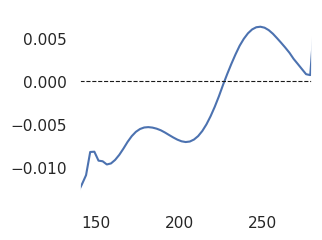

In [207]:
sel = lambda x: x.sel(month=PLOT_MONTH, latitude=slice(-5, 5)).mean("latitude")

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.plot(mu_a.longitude, sel(mu_a["late"] - mu_a["early"]))
ax.axhline(0, ls="--", c="k", lw=0.8)
ax.set_xlim([140, 280])
plt.show()

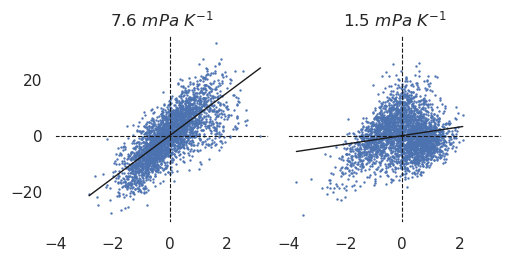

In [208]:
## kwargs for plotting
kwargs = dict(months=PLOT_MONTH, scale=1e3, fn_y=TAU_FN, x_var=T_VAR, y_var="taux")

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.1f}" + r" $mPa~K^{-1}$")
axs[1].set_title(f"{m1:.1f}" + r" $mPa~K^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

### $\tau_x$ - $Z_{20}$

In [209]:
## shared kwargs
kwargs = dict(x_var="taux", y_var="z20")

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, fn_x=TAU_FN, **kwargs)
m_late = get_slope_bymonth(anom_late, fn_x=TAU_FN, **kwargs)
beta_h_int = xr.merge([m_early.rename("early"), m_late.rename("late")])
beta_h_grad = beta_h_int.differentiate("longitude")

##### Hovmoller

Note: could plot $\frac{dh}{dx}$ here...lines up better with shift in wind pattern...

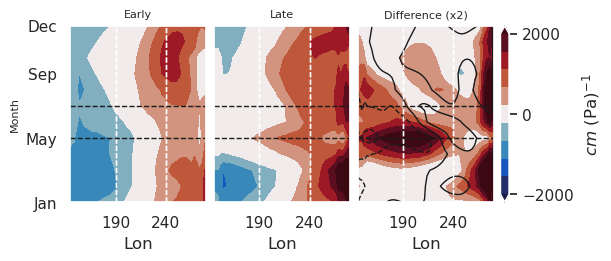

In [210]:
## shared args
kwargs = dict(amp=2e3, lat_bound=2)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=beta_h_int["early"], **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=beta_h_int["late"], **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * (beta_h_int["late"] - beta_h_int["early"]), **kwargs
)

axs[2].contour(
    mu_a.longitude,
    mu_a.month,
    (mu_a["late"] - mu_a["early"]).sel(latitude=slice(-5, 5)).mean("latitude"),
    colors="k",
    linewidths=1,
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$cm~\left(\text{Pa}\right)^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

Scatter

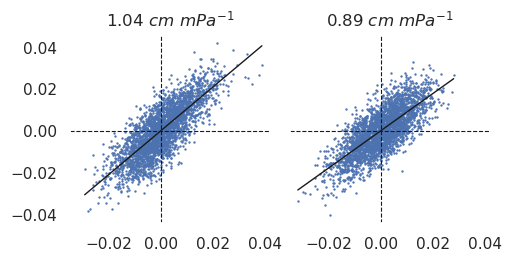

In [211]:
## kwargs for plotting
kwargs = dict(months=6, scale=1e-3, x_var="taux", y_var="z20", fn_y=Hgrad_FN)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, fn_x=TAU_FN, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, fn_x=TAU_FN, **kwargs)

## label
axs[0].set_title(f"{m0:.2f}" + r" $cm~mPa^{-1}$")
axs[1].set_title(f"{m1:.2f}" + r" $cm~mPa^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

Spatial plot

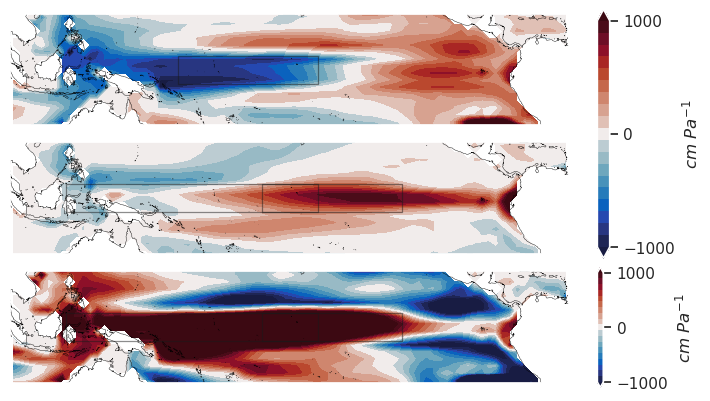

In [212]:
## specify plot var and amplitude
# PLOT_VAR = beta_h_grad
# AMP = 5e1
PLOT_VAR = beta_h_int
AMP = 1e3

## select month
sel = lambda x: x.sel(month=PLOT_MONTH)

## set up plot
fig = plt.figure(figsize=(7, 3.9), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=format_func)

contour_kwargs = dict(amp=AMP, sel=sel)
cp0 = src.utils.make_contour_plot(axs[0, 0], PLOT_VAR["early"], **contour_kwargs)
cp1 = src.utils.make_contour_plot(axs[1, 0], PLOT_VAR["late"], **contour_kwargs)
cp2 = src.utils.make_contour_plot(
    axs[2, 0],
    (PLOT_VAR["late"] - PLOT_VAR["early"]),
    **dict(contour_kwargs, amp=AMP / 2)
)

## colorbar
lab = r"$cm~Pa^{-1}$"
cb0 = fig.colorbar(cp0, ax=axs[:2], ticks=[-AMP, 0, AMP], label=lab)
cb2 = fig.colorbar(cp2, ax=axs[-1], ticks=[-AMP, 0, AMP], label=lab)

## Niño 3 box
box_kwargs = dict(c="k", linewidth=0.9, alpha=0.5)
src.utils.plot_nino4_box(axs[0, 0], **box_kwargs)
for ax in axs[1:].flatten():
    src.utils.plot_nino34_box(ax, **box_kwargs)
    src.utils.plot_hw_box(ax, **box_kwargs)
    # src.utils.plot_nino3_box(ax, **box_kwargs)

plt.show()

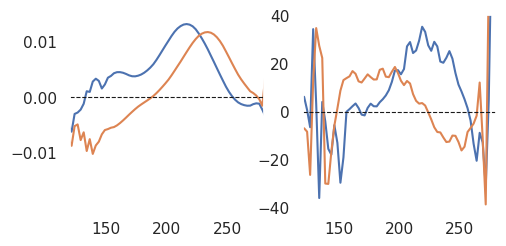

In [213]:
sel = lambda x: x.sel(month=PLOT_MONTH, latitude=slice(-5, 5)).mean("latitude")

fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

## plot wind
axs[0].plot(mu_a.longitude, sel(mu_a["early"]))
axs[0].plot(mu_a.longitude, sel(mu_a["late"]))

## plot thermocline
axs[1].plot(mu_a.longitude, sel(beta_h_grad["early"]))
axs[1].plot(mu_a.longitude, sel(beta_h_grad["late"]))
axs[1].set_ylim([-40, 40])

## plot thermocline
# ax2 = ax.twinx()
# ax2.plot(mu_a.longitude, sel(beta_h_int["late"]))


## format
for ax in axs:
    ax.axhline(0, ls="--", c="k", lw=0.8)
    ax.set_xlim([120, 280])
plt.show()

Subsurface plot

In [214]:
## shared kwargs
kwargs = dict(x_var="taux", y_var="T")

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, fn_x=TAU_FN, **kwargs)
m_late = get_slope_bymonth(anom_late, fn_x=TAU_FN, **kwargs)

In [215]:
## get climatologies
T_forced = forced[["T", "T_comp", "z20", "z20_comp"]]
T_forced = (
    src.utils.sel_month(T_forced, PLOT_MONTH)
    .sel(latitude=slice(-2, 2))
    .mean("latitude")
)
T_clim_early = src.utils.reconstruct_wrapper(T_forced.sel(t_early).mean("time"))
T_clim_late = src.utils.reconstruct_wrapper(T_forced.sel(t_late).mean("time"))

## get scale for taux
sigma_taux = src.utils.reconstruct_std(
    scores=anom_early["taux"],
    components=anom_early["taux_comp"],
    fn=TAU_FN,
)

# ## Get typical thermocline deviation
SCALE = sigma_taux * 3
sel_ = lambda x: x.sel(latitude=slice(-2, 2), month=PLOT_MONTH).mean("latitude")
z20_early = T_clim_early["z20"] + sel_(beta_h_int["early"]) * SCALE
z20_late = T_clim_late["z20"] + sel_(beta_h_int["late"]) * SCALE

## scale T anomalies by same amount
m_early_ = m_early.sel(month=PLOT_MONTH) * SCALE
m_late_ = m_late.sel(month=PLOT_MONTH) * SCALE

## put everything in xr.datasets
T_early = xr.merge([T_clim_early["T"].rename("clim"), m_early_.rename("anom")])
T_late = xr.merge([T_clim_late["T"].rename("clim"), m_late_.rename("anom")])

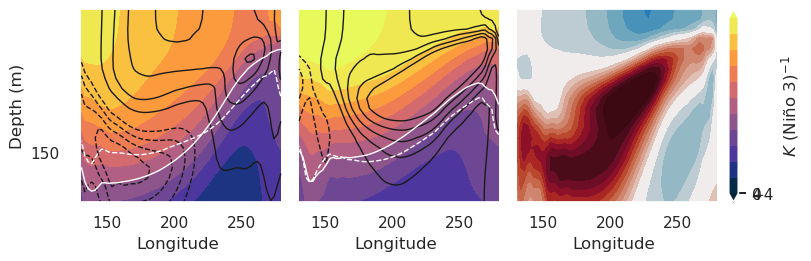

In [216]:
## specify amplitude
amp = 4

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), layout="constrained")

for ax, T_, lev in zip(axs[:2], [T_early, T_late], [20, 20]):

    ## temperature
    cp = ax.contourf(
        T_.longitude,
        T_.z_t,
        T_["clim"],
        cmap="cmo.thermal",
        levels=np.arange(10, 34, 2),
        extend="both",
    )

    ## warming pattern
    ax.contour(
        T_.longitude,
        T_.z_t,
        T_["anom"],
        colors="k",
        levels=src.utils.make_cb_range(amp, amp / 5),
        extend="both",
        linewidths=1,
    )

    ## highlight z20
    plot_level(ax, T_["clim"], level=lev)
    plot_level(ax, T_["clim"] + T_["anom"], level=lev, ls="--")

## difference
axs[2].contourf(
    m_early.longitude,
    m_early.z_t,
    (T_late - T_early)["anom"],
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(amp, amp / 10),
    extend="both",
)

## set ax limit and plot Niño 3.4 bounds
cb = fig.colorbar(
    cp, ax=axs[2], ticks=[-amp, 0, amp], label=r"$K~\left(\text{Niño 3}\right)^{-1}$"
)
src.utils.format_subsurf_axs(axs)
for ax in axs:
    ax.set_xlim([125, 280])
    ax.set_ylim([200, 5])

plt.show()

### $\tau_x$-SSH

In [217]:
## shared kwargs
kwargs = dict(x_var="taux", y_var="ssh")

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, fn_x=TAU_FN, **kwargs)
m_late = get_slope_bymonth(anom_late, fn_x=TAU_FN, **kwargs)
beta_h_ssh = xr.merge([m_early.rename("early"), m_late.rename("late")])

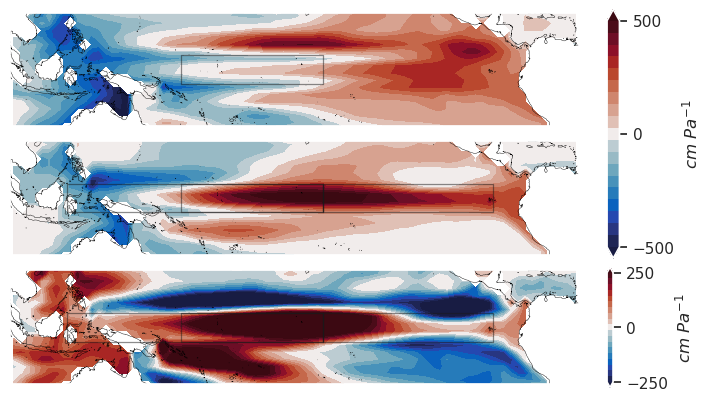

In [218]:
## specify plot var and amplitude
# PLOT_VAR = beta_h_grad
# AMP = 5e1
PLOT_VAR = beta_h_ssh
AMP = 5e2

## select month
sel = lambda x: x.sel(month=PLOT_MONTH)

## set up plot
fig = plt.figure(figsize=(7, 3.9), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=format_func)

contour_kwargs = dict(amp=AMP, sel=sel)
cp0 = src.utils.make_contour_plot(axs[0, 0], PLOT_VAR["early"], **contour_kwargs)
cp1 = src.utils.make_contour_plot(axs[1, 0], PLOT_VAR["late"], **contour_kwargs)
cp2 = src.utils.make_contour_plot(
    axs[2, 0],
    (PLOT_VAR["late"] - PLOT_VAR["early"]),
    **dict(contour_kwargs, amp=AMP / 2)
)

## colorbar
lab = r"$cm~Pa^{-1}$"
cb0 = fig.colorbar(cp0, ax=axs[:2], ticks=[-AMP, 0, AMP], label=lab)
cb2 = fig.colorbar(cp2, ax=axs[-1], ticks=[-AMP / 2, 0, AMP / 2], label=lab)

## Niño 3 box
box_kwargs = dict(c="k", linewidth=0.9, alpha=0.5)
src.utils.plot_nino4_box(axs[0, 0], **box_kwargs)
for ax in axs[1:].flatten():
    src.utils.plot_nino3_box(ax, **box_kwargs)
    src.utils.plot_hw_box(ax, **box_kwargs)
    src.utils.plot_nino4_box(ax, **box_kwargs)

plt.show()

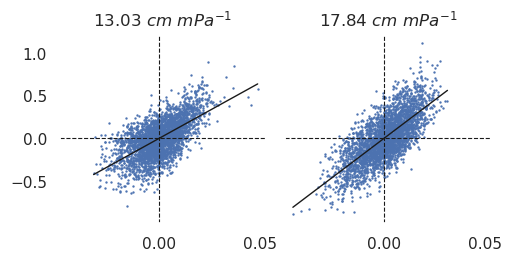

In [219]:
kwargs = dict(months=6, scale=5e-2, x_var="taux", y_var="ssh", fn_y=Hgrad_FN)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, fn_x=src.utils.get_nino4, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, fn_x=src.utils.get_nino34, **kwargs)

## label
axs[0].set_title(f"{m0:.2f}" + r" $cm~mPa^{-1}$")
axs[1].set_title(f"{m1:.2f}" + r" $cm~mPa^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

### $Z_{20} - T_{sub}$

In [220]:
## shared kwargs
# kwargs = dict(x_var="z20", y_var="T", fn_x=T_FN)
kwargs = dict(x_var="z20", y_var="T", fn_x=He_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)
a_h = xr.merge([m_early.rename("early"), m_late.rename("late")])

Hovmoller

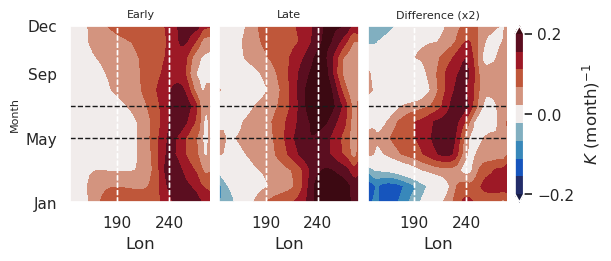

In [221]:
## specify Hm
Hm = 70
sel = lambda x: x.sel(z_t=Hm, method="nearest")

## shared args
kwargs = dict(amp=0.2, lat_bound=2)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=sel(a_h["early"]), **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=sel(a_h["late"]), **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * sel(a_h["late"] - a_h["early"]), **kwargs
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$K~\left(\text{month}\right)^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

Scatter

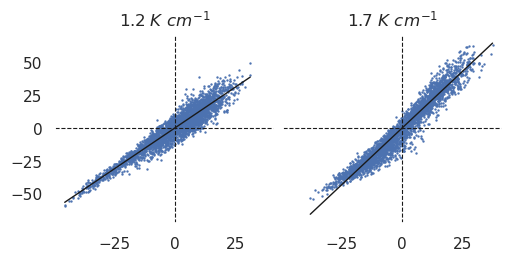

In [222]:
## kwargs for plotting
kwargs = dict(
    months=6,
    scale=1e1,
    x_var="z20",
    y_var="T",
    fn_x=He_FN,
    fn_y=lambda x: Tsub_FN(x, H=70),
)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.1f}" + r" $K~cm^{-1}$")
axs[1].set_title(f"{m1:.1f}" + r" $K~cm^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

Spatial

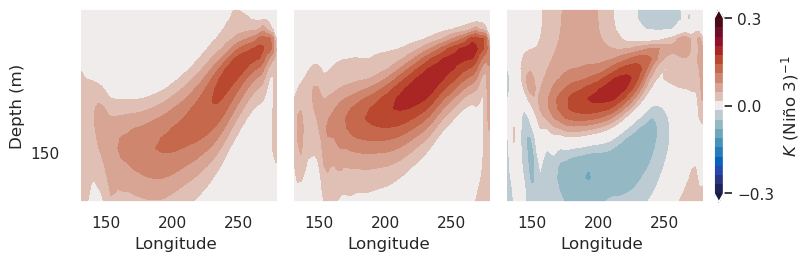

In [223]:
## specify amplitude
amp = 0.3

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), layout="constrained")

for ax, n, lev in zip(axs[:2], ["early", "late"], [20, 20]):

    ## temperature
    cp = ax.contourf(
        a_h.longitude,
        a_h.z_t,
        a_h[n].sel(month=PLOT_MONTH),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(amp, amp / 10),
        extend="both",
    )

## difference
axs[2].contourf(
    a_h.longitude,
    a_h.z_t,
    (a_h["late"] - a_h["early"]).sel(month=PLOT_MONTH),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(amp / 2, amp / 20),
    extend="both",
)

## set ax limit and plot Niño 3.4 bounds
cb = fig.colorbar(
    cp, ax=axs[2], ticks=[-amp, 0, amp], label=r"$K~\left(\text{Niño 3}\right)^{-1}$"
)
src.utils.format_subsurf_axs(axs)
for ax in axs:
    ax.set_xlim([125, 280])
    ax.set_ylim([200, 5])

plt.show()

### SSH - $T_{sub}$

In [224]:
## shared kwargs
kwargs = dict(x_var="ssh", y_var="T", fn_x=He_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)
a_h_ssh = xr.merge([m_early.rename("early"), m_late.rename("late")])

Hovmoller

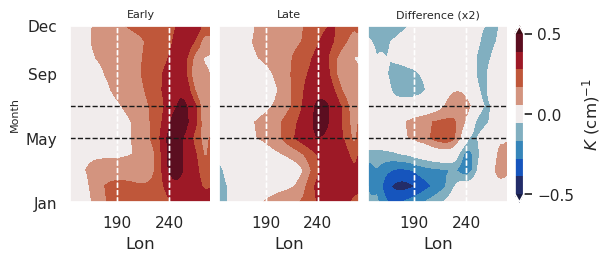

In [225]:
## specify Hm
Hm = 70
sel = lambda x: x.sel(z_t=Hm, method="nearest")

## shared args
kwargs = dict(amp=0.5, lat_bound=2)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=sel(a_h_ssh["early"]), **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=sel(a_h_ssh["late"]), **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * sel(a_h_ssh["late"] - a_h_ssh["early"]), **kwargs
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$K~\left(\text{cm}\right)^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

Scatter

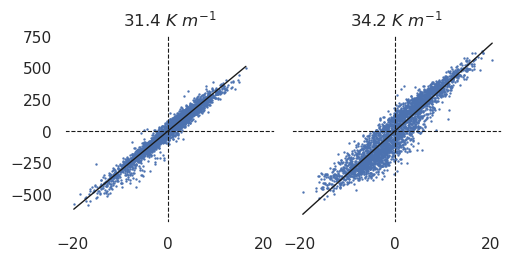

In [226]:
## kwargs for plotting
kwargs = dict(
    months=6,
    scale=1e2,
    x_var="ssh",
    y_var="T",
    fn_x=He_FN,
    fn_y=lambda x: Tsub_FN(x, H=70),
)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.1f}" + r" $K~m^{-1}$")
axs[1].set_title(f"{m1:.1f}" + r" $K~m^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

Spatial

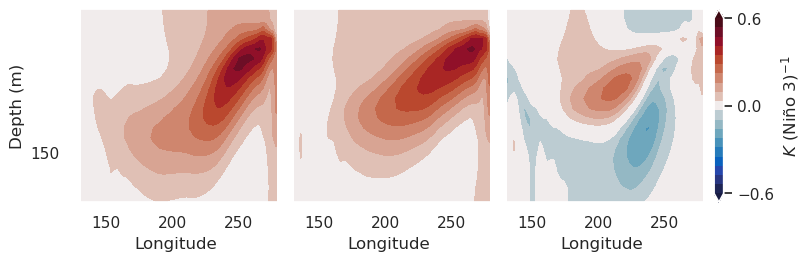

In [227]:
## specify amplitude
amp = 0.6

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), layout="constrained")

for ax, n, lev in zip(axs[:2], ["early", "late"], [20, 20]):

    ## temperature
    cp = ax.contourf(
        a_h_ssh.longitude,
        a_h_ssh.z_t,
        a_h_ssh[n].sel(month=PLOT_MONTH),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(amp, amp / 10),
        extend="both",
    )

## difference
axs[2].contourf(
    a_h_ssh.longitude,
    a_h_ssh.z_t,
    (a_h_ssh["late"] - a_h_ssh["early"]).sel(month=PLOT_MONTH),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(amp / 2, amp / 20),
    extend="both",
)

## set ax limit and plot Niño 3.4 bounds
cb = fig.colorbar(
    cp, ax=axs[2], ticks=[-amp, 0, amp], label=r"$K~\left(\text{Niño 3}\right)^{-1}$"
)
src.utils.format_subsurf_axs(axs)
for ax in axs:
    ax.set_xlim([125, 280])
    ax.set_ylim([200, 5])

plt.show()

### $T-\Delta_x h$

In [228]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="z20", fn_x=T_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)

## merge
beta_T_int = xr.merge([m_early.rename("early"), m_late.rename("late")])

Hovmoller

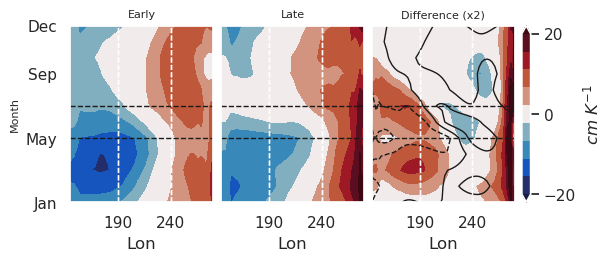

In [229]:
## shared args
kwargs = dict(amp=20, lat_bound=5)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=beta_T_int["early"], **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=beta_T_int["late"], **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * (beta_T_int["late"] - beta_T_int["early"]), **kwargs
)

axs[2].contour(
    mu_a.longitude,
    mu_a.month,
    (mu_a["late"] - mu_a["early"]).sel(latitude=slice(-5, 5)).mean("latitude"),
    colors="k",
    linewidths=1,
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$cm~K^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

Spatial

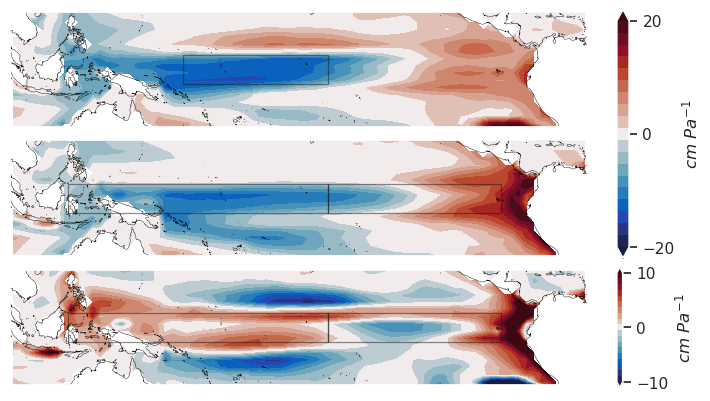

In [230]:
## specify plot var and amplitude
PLOT_VAR = beta_T_int
AMP = 20
# PLOT_VAR = beta_T_int.differentiate("longitude")
# AMP = 1

## select month
sel = lambda x: x.sel(month=PLOT_MONTH)

## set up plot
fig = plt.figure(figsize=(7, 3.9), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=format_func)

contour_kwargs = dict(amp=AMP, sel=sel)
cp0 = src.utils.make_contour_plot(axs[0, 0], PLOT_VAR["early"], **contour_kwargs)
cp1 = src.utils.make_contour_plot(axs[1, 0], PLOT_VAR["late"], **contour_kwargs)
cp2 = src.utils.make_contour_plot(
    axs[2, 0],
    (PLOT_VAR["late"] - PLOT_VAR["early"]),
    **dict(contour_kwargs, amp=AMP / 2)
)

## colorbar
lab = r"$cm~Pa^{-1}$"
cb0 = fig.colorbar(cp0, ax=axs[:2], ticks=[-AMP, 0, AMP], label=lab)
cb2 = fig.colorbar(cp2, ax=axs[-1], ticks=[-AMP / 2, 0, AMP / 2], label=lab)

## Niño 3 box
box_kwargs = dict(c="k", linewidth=0.9, alpha=0.5)
src.utils.plot_nino4_box(axs[0, 0], **box_kwargs)
for ax in axs[1:].flatten():
    src.utils.plot_nino3_box(ax, **box_kwargs)
    src.utils.plot_hw_box(ax, **box_kwargs)
    # src.utils.plot_nino3_box(ax, **box_kwargs)

plt.show()

Scatter

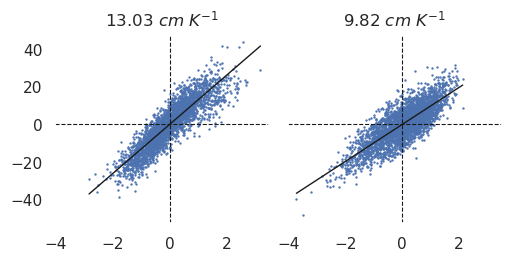

In [231]:
## kwargs for plotting
kwargs = dict(
    months=PLOT_MONTH,
    scale=1,
    x_var="sst",
    y_var="z20",
    fn_x=T_FN,
    fn_y=Hgrad_FN,
)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.2f}" + r" $cm~K^{-1}$")
axs[1].set_title(f"{m1:.2f}" + r" $cm~K^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

### $T-\Delta_x$SSH

In [232]:
## shared kwargs
kwargs = dict(x_var="sst", y_var="ssh", fn_x=T_FN)

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, **kwargs)
m_late = get_slope_bymonth(anom_late, **kwargs)

## merge
beta_T_ssh = xr.merge([m_early.rename("early"), m_late.rename("late")])

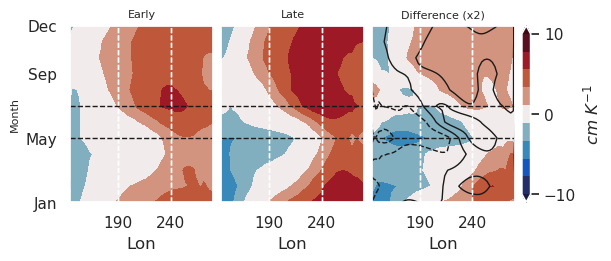

In [233]:
## shared args
kwargs = dict(amp=10, lat_bound=1.5)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=beta_T_ssh["early"], **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=beta_T_ssh["late"], **kwargs)
cp2 = src.utils.make_cycle_hov(
    axs[2], data=2 * (beta_T_ssh["late"] - beta_T_ssh["early"]), **kwargs
)

axs[2].contour(
    mu_a.longitude,
    mu_a.month,
    (mu_a["late"] - mu_a["early"]).sel(latitude=slice(-5, 5)).mean("latitude"),
    colors="k",
    linewidths=1,
)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$cm~K^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

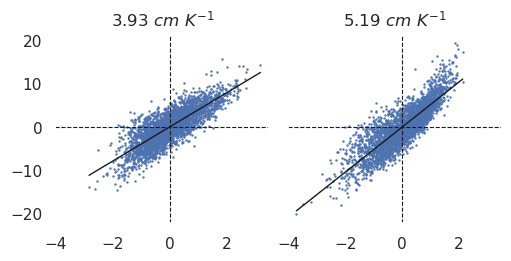

In [234]:
## kwargs for plotting
kwargs = dict(
    months=PLOT_MONTH,
    scale=1,
    x_var="sst",
    y_var="ssh",
    fn_x=T_FN,
    fn_y=Hgrad_FN,
)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, **kwargs)

## label
axs[0].set_title(f"{m0:.2f}" + r" $cm~K^{-1}$")
axs[1].set_title(f"{m1:.2f}" + r" $cm~K^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)

spatial plot

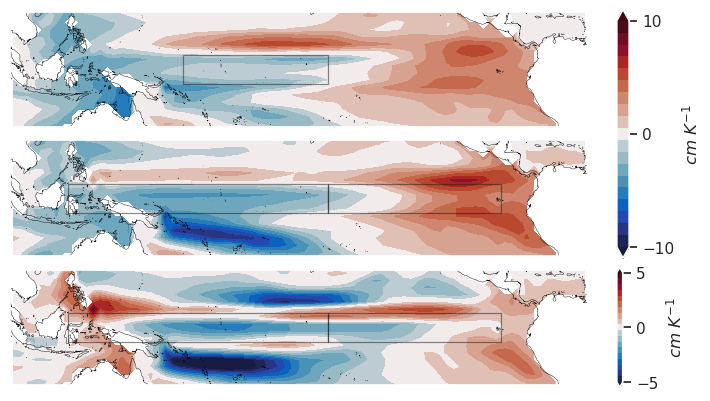

In [235]:
## specify plot var and amplitude
PLOT_VAR = beta_T_ssh
AMP = 10
# PLOT_VAR = beta_T_int.differentiate("longitude")
# AMP = 1

## select month
sel = lambda x: x.sel(month=PLOT_MONTH)

## set up plot
fig = plt.figure(figsize=(7, 3.9), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=format_func)

contour_kwargs = dict(amp=AMP, sel=sel)
cp0 = src.utils.make_contour_plot(axs[0, 0], PLOT_VAR["early"], **contour_kwargs)
cp1 = src.utils.make_contour_plot(axs[1, 0], PLOT_VAR["late"], **contour_kwargs)
cp2 = src.utils.make_contour_plot(
    axs[2, 0],
    (PLOT_VAR["late"] - PLOT_VAR["early"]),
    **dict(contour_kwargs, amp=AMP / 2)
)

## colorbar
lab = r"$cm~K^{-1}$"
cb0 = fig.colorbar(cp0, ax=axs[:2], ticks=[-AMP, 0, AMP], label=lab)
cb2 = fig.colorbar(cp2, ax=axs[-1], ticks=[-AMP / 2, 0, AMP / 2], label=lab)

## Niño 3 box
box_kwargs = dict(c="k", linewidth=0.9, alpha=0.5)
src.utils.plot_nino4_box(axs[0, 0], **box_kwargs)
for ax in axs[1:].flatten():
    src.utils.plot_nino3_box(ax, **box_kwargs)
    src.utils.plot_hw_box(ax, **box_kwargs)
    # src.utils.plot_nino3_box(ax, **box_kwargs)

plt.show()

## Check recon

### Compute

In [236]:
def get_coefs_and_recon(
    data,
    beta_h_int,
    beta_T_int,
    mu_a,
    a_h,
    tau_fn,
    use_beta_T=False,
    month=6,
    h_var="z20",
    T_var="T_34",
    Hm=70,
):
    """get area-averaged coefficients and reconstruction"""

    ## func to select Tsub based on specified Hm
    Tsub_FN_ = lambda T: Tsub_FN(T, H=Hm)

    ## subset data for month
    data_ = src.utils.sel_month(data, months=month)

    ## compute coefficients
    mu_a_ = tau_fn(mu_a).sel(month=month)
    beta_h_ = Hgrad_FN(beta_h_int).sel(month=month)
    a_h_ = Tsub_FN_(a_h).sel(month=month)

    ## compute beta_T if necessary
    if use_beta_T:
        beta_T_ = Hgrad_FN(beta_T_int).sel(month=month)
    else:
        beta_T_ = beta_h_ * mu_a_

    ## compute Tsub
    data_T = data_[["T", "T_comp"]]
    Tsub = src.utils.reconstruct_wrapper(data_T, fn=Tsub_FN_)["T"]

    ## compute thermocline slope
    data_z20 = data_[[h_var, f"{h_var}_comp"]]
    dh = src.utils.reconstruct_wrapper(data_z20, fn=Hgrad_FN)[h_var]

    ## thermocline in east/west
    he = src.utils.reconstruct_wrapper(data_z20, fn=He_FN)[h_var]
    hw = src.utils.reconstruct_wrapper(data_z20, fn=Hw_FN)[h_var]

    ## Niño 3.4
    T = data_[T_var]

    ## get predicted thermocline slope
    dh_hat = beta_T_ * T

    ## get predicted thermocline depth in east
    he_hat = hw + dh_hat

    ## get predicted subsurface temp
    Tsub_hat = he_hat * a_h_

    ## put everything in dataarray
    res = xr.merge(
        [
            T.rename("T"),
            hw.rename("hw"),
            dh.rename("dh"),
            dh_hat.rename("dh_hat"),
            he.rename("he"),
            he_hat.rename("he_hat"),
            Tsub.rename("Tsub"),
            Tsub_hat.rename("Tsub_hat"),
            mu_a_.rename("mu_a"),
            beta_h_.rename("beta_h"),
            beta_T_.rename("beta_T"),
            a_h_.rename("a_h"),
        ]
    )

    return res


def get_coefs_fit(res_):
    """get best-fit coefficients"""

    ## shared args
    kwargs = dict(x_vars=["T", "hw"], y_vars=["Tsub"])

    ## least-squares fit
    m = src.utils.regress_xr_proj(res_, **kwargs)["Tsub"].to_dataset("j")

    ## get coefficients
    a_h = m["hw"]
    beta_T = m["T"] / a_h

    return xr.merge([beta_T.rename("beta_T"), a_h.rename("a_h")])


def get_coefs_and_recon2(res_):
    """get reconstruction using best-fit coefficients"""

    ## get best fit
    res2 = get_coefs_fit(res_)

    ## get recon
    res2["Tsub_hat"] = res2["a_h"] * (res2["beta_T"] * res_["T"] + res_["hw"])

    ## add ground truth
    res2["Tsub"] = res_["Tsub"]

    return res2

In [303]:
## shared args
kwargs = dict(
    use_beta_T=True,  ## specify: should we use beta_T?
    h_var="z20",
    T_var=T_VAR,
    month=6,
    Hm=70,
)

if kwargs["h_var"] == "ssh":
    beta_h_ = beta_h_ssh
    beta_T_ = beta_T_ssh
    a_h_ = a_h_ssh
else:
    beta_h_ = beta_h_int
    beta_T_ = beta_T_int
    a_h_ = a_h

## get early
res_early = get_coefs_and_recon(
    data=anom_early,
    mu_a=mu_a["early"],
    a_h=a_h_["early"],
    beta_h_int=beta_h_["early"],
    beta_T_int=beta_T_["early"],
    tau_fn=TAU_FN,
    **kwargs
)

## get late
res_late = get_coefs_and_recon(
    data=anom_late,
    beta_h_int=beta_h_["late"],
    beta_T_int=beta_T_["late"],
    mu_a=mu_a["late"],
    a_h=a_h_["late"],
    tau_fn=TAU_FN,
    **kwargs
)

### Plot results

#### $\Delta_x h$

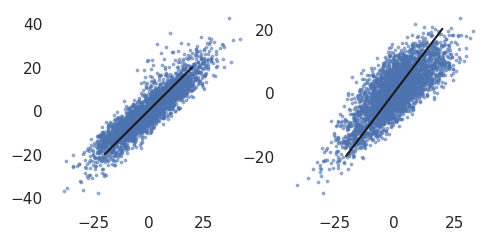

In [304]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

## plot early and late
for ax, res in zip(axs, [res_early, res_late]):
    ax.scatter(
        res["dh"],
        res["dh_hat"],
        s=3,
        alpha=0.5,
    )
    zz = np.linspace(-20, 20)
    ax.plot(zz, zz, c="k")

plt.show()

#### $h_e$

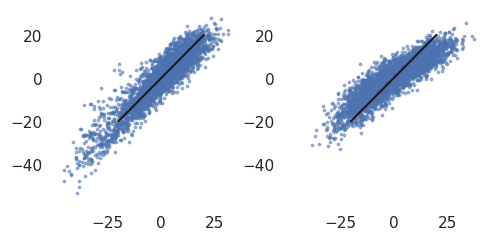

In [305]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

for ax, res in zip(axs, [res_early, res_late]):
    ax.scatter(
        res["he"],
        res["he_hat"],
        s=3,
        alpha=0.5,
    )
    zz = np.linspace(-20, 20)
    ax.plot(zz, zz, c="k")

src.utils.set_lims(axs)
plt.show()

#### $T_{sub}$

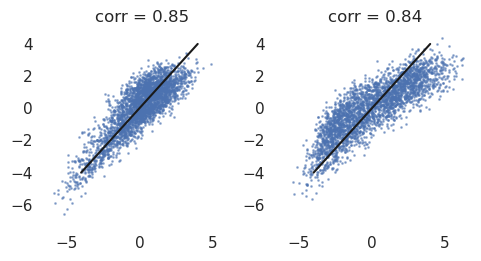

In [306]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

for ax, res in zip(axs, [res_early, res_late]):

    ax.scatter(
        res["Tsub"],
        res["Tsub_hat"],
        s=1,
        alpha=0.5,
    )
    zz = np.linspace(-4, 4)
    ax.plot(zz, zz, c="k")

    ## label with correlation
    corr = xr.corr(res["Tsub"], res["Tsub_hat"]).values.item()
    ax.set_title(f"corr = {corr:.2f}")

src.utils.set_lims(axs)
plt.show()

#### statistical approach

In [307]:
res2_early = get_coefs_and_recon2(res_early)
res2_late = get_coefs_and_recon2(res_late)

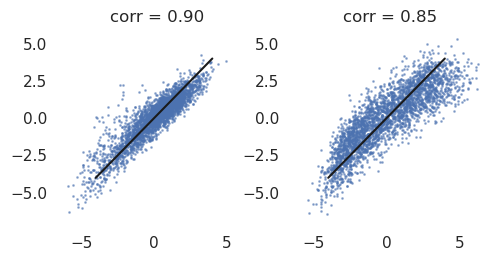

In [308]:
corr_early = xr.corr(res_early["Tsub"], res_early["Tsub_hat"]).values.item()
corr_late = xr.corr(res_late["Tsub"], res_late["Tsub_hat"]).values.item()

fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

for ax, res in zip(axs, [res2_early, res2_late]):
    ax.scatter(
        res["Tsub"],
        res["Tsub_hat"],
        s=1,
        alpha=0.5,
    )
    zz = np.linspace(-4, 4)
    ax.plot(zz, zz, c="k")

    ## label with correlation
    corr = xr.corr(res["Tsub"], res["Tsub_hat"]).values.item()
    ax.set_title(f"corr = {corr:.2f}")

src.utils.set_lims(axs)
plt.show()

In [309]:
frac_change = (res_late - res_early) / res_early
frac_change2 = (res2_late - res2_early) / res2_early
for l, c in zip(["physical", "statistical"], [frac_change, frac_change2]):
    print(l)
    for n in ["beta_T", "a_h"]:
        print(f"{n:>7}: {c[n]*100:.0f}%")
    print(f"")

physical
 beta_T: -31%
    a_h: 39%

statistical
 beta_T: -63%
    a_h: 133%



## Scratch

### $\tau_x-T_{sub}$
Note: there's no quasi-balance condition for this; $\tau_x$ tells us tilt of the thermocline, not depth

In [ ]:
## shared kwargs
kwargs = dict(x_var="taux", y_var="T")

## then, reconstruct regression coefficient
m_early = get_slope_bymonth(anom_early, fn_x=src.utils.get_nino4, **kwargs)
m_late = get_slope_bymonth(anom_late, fn_x=src.utils.get_nino34, **kwargs)

In [ ]:
## specify Hm
Hm = 70
sel = lambda x: x.sel(z_t=Hm, method="nearest")

## shared args
kwargs = dict(amp=3e2, lat_bound=1.5)

fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), layout="constrained")

## plot data
cp0 = src.utils.make_cycle_hov(axs[0], data=sel(m_early), **kwargs)
cp1 = src.utils.make_cycle_hov(axs[1], data=sel(m_late), **kwargs)
cp2 = src.utils.make_cycle_hov(axs[2], data=2 * sel(m_late - m_early), **kwargs)

## make it look nicer
cb = fig.colorbar(
    cp0,
    ax=axs[2],
    ticks=[-kwargs["amp"], 0, kwargs["amp"]],
    label=r"$K~\left(\text{month}\right)^{-1}$",
)
src.utils.format_hov_axs(axs)
for ax in axs:
    for t in [5, 7]:
        ax.axhline(t, ls="--", c="k", lw=1)

plt.show()

In [ ]:
sel_T = (
    lambda x: x.sel(longitude=slice(210, 280))
    .mean("longitude")
    .sel(z_t=Hm, method="nearest")
)

## kwargs for plotting
kwargs = dict(months=6, scale=1e-2, x_var="taux", y_var="T", fn_y=sel_T)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")
m0 = src.utils.make_scatter2(axs[0], anom_early, fn_x=src.utils.get_nino4, **kwargs)
m1 = src.utils.make_scatter2(axs[1], anom_late, fn_x=src.utils.get_nino34, **kwargs)

## label
axs[0].set_title(f"{m0:.1f}" + r" $K~hPa^{-1}$")
axs[1].set_title(f"{m1:.1f}" + r" $K~hPa^{-1}$")
axs[1].set_yticks([])

src.utils.set_lims(axs)